# Implement the Stochastic Block Model inference

Tasks:

1. Create a SBM model which generates a network with (𝐾,𝑠𝑖,𝑃𝑖𝑗
) parameters.
2. Write a function which calculates the likelihood for any network given by the set of parameters (𝐾,𝑠,𝑃𝑖𝑗
)
3. We will try to inference back the parameters with which we created the network.
4. Do the simulated annealing, several time for a given 𝐾
. The elementary step is that for fixed 𝐾
 we move a node from a block 𝑖
 to block 𝑗
. If the likelihood increases accept the new configuration otherwise accept it with probability 𝑝=exp(−(log(𝐿𝑜𝑙𝑑)−log(𝐿𝑛𝑒𝑤))/𝑇)
5. Do the above for different 𝐾
, and plot the best log likelihood as log−(𝐾−1)2
 vs. 𝐾
. Try to identify the best partition.
6. Plot the network for the best partition with different colors for different block (color the nodes: if 𝑐
 is an integer array with the same length as number of nodes in the graph, then the following line does the trick, if you do not like to colors (you won't) then change the colormap):
nx.draw(G,node_color=c)

**Libraries**

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import math

**SBM Generation**

In [ ]:
def generate_sbm(K, s, P):
    if len(s) != K or len(P) != K or any(len(row) != K for row in P):
        raise ValueError("Mismatch between K and the dimensions of s and P")
    G = nx.stochastic_block_model(s, P)
    return G

**Likelihood Calculation**

In [ ]:
def calculate_likelihood(G, K, s, P):
    likelihood = 0
    for u, v in G.edges():
        block_u = G.nodes[u]['block']
        block_v = G.nodes[v]['block']
        likelihood += np.log(P[block_u][block_v])
    for u, v in nx.non_edges(G):
        block_u = G.nodes[u]['block']
        block_v = G.nodes[v]['block']
        likelihood += np.log(1 - P[block_u][block_v])
    return likelihood

**Simulated Annealing**

In [ ]:
def simulated_annealing(G, K, s, P, T, steps=1000):
    current_likelihood = calculate_likelihood(G, K, s, P)
    best_partition = nx.get_node_attributes(G, 'block')
    best_likelihood = current_likelihood
    for step in range(steps):
        node = np.random.choice(G.nodes())
        current_block = G.nodes[node]['block']
        new_block = np.random.choice(list(set(range(K)) - {current_block}))
        # Move node to new block
        G.nodes[node]['block'] = new_block
        new_likelihood = calculate_likelihood(G, K, s, P)
        if new_likelihood > current_likelihood or np.random.rand() < np.exp((new_likelihood - current_likelihood) / T):
            current_likelihood = new_likelihood
            if new_likelihood > best_likelihood:
                best_likelihood = new_likelihood
                best_partition = nx.get_node_attributes(G, 'block')
        else:
            G.nodes[node]['block'] = current_block
    return best_partition, best_likelihood

**Plot**

In [ ]:
def plot_network(G, partition):
    node_colors = [partition[i] for i in G.nodes()]
    plt.figure(figsize=(10, 8))
    nx.draw(G, node_color=node_colors, with_labels=False, node_size=100, cmap='viridis')
    plt.show()

**Run 1: K=2**

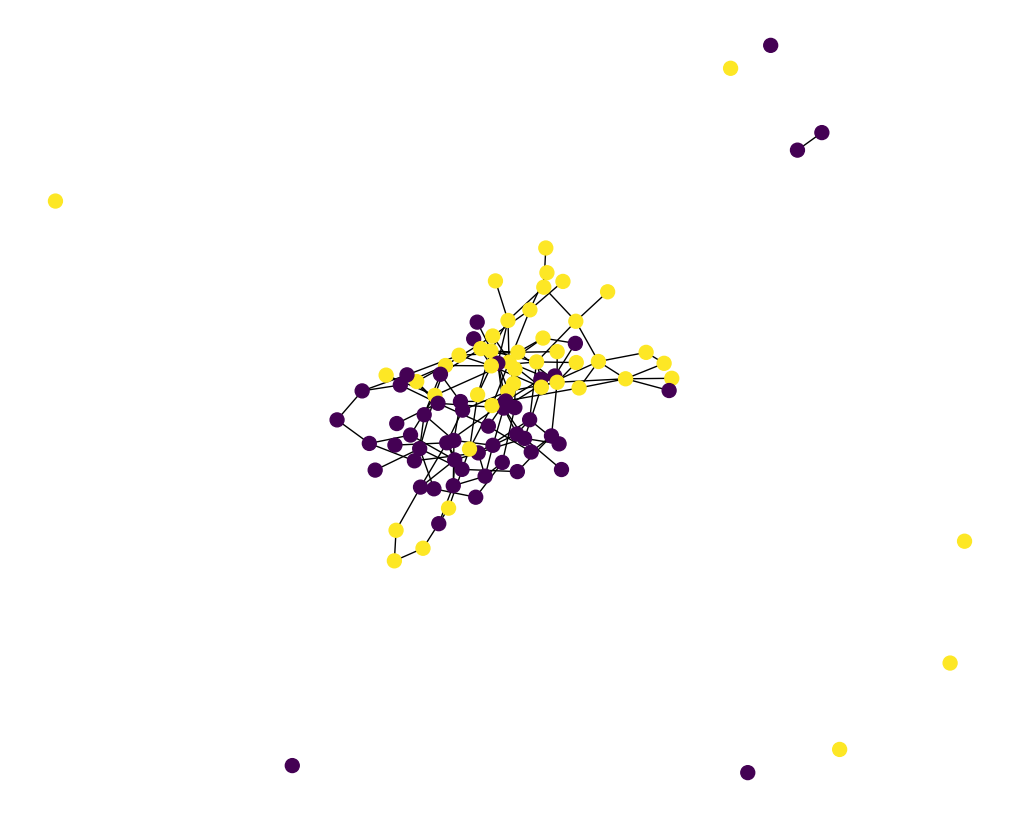

In [ ]:
K = 2
s = [50, 50]
P = [[0.05, 0.01], [0.01, 0.05]]
G = generate_sbm(K, s, P)
partition, _ = simulated_annealing(G, K, s, P, T=1)
plot_network(G, partition)

**Run 2: K=3**

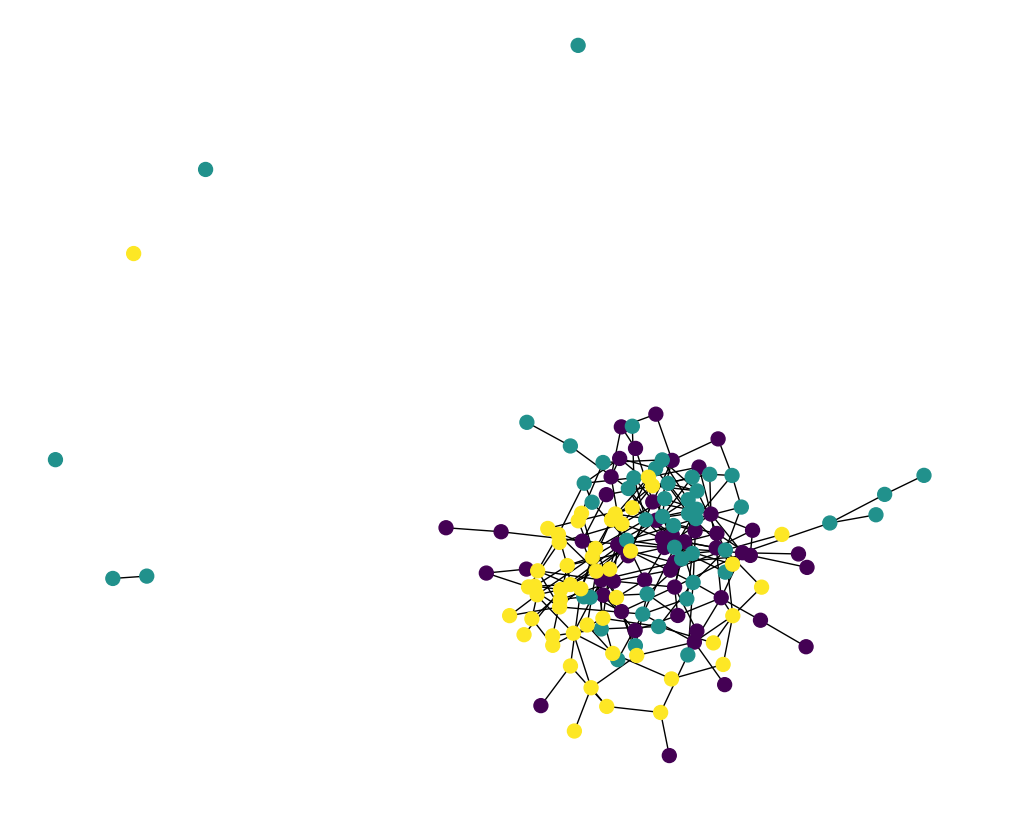

In [ ]:
K = 3
s = [50, 50, 50]
P = [[0.05, 0.01, 0.01], [0.01, 0.05, 0.01], [0.01, 0.01, 0.05]]
G = generate_sbm(K, s, P)
partition, _ = simulated_annealing(G, K, s, P, T=1)
plot_network(G, partition)


**Using Real Network: 'a.dot'**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot

# Load the .dot file content
dot_file_path = 'a.dot'
with open(dot_file_path, 'r') as file:
    dot_content = file.read()

# Clean up the dot content to avoid stray labels
cleaned_dot_content = ''.join(line for line in dot_content.splitlines() if line.strip())

# Use pydot to parse the cleaned dot content
graphs = pydot.graph_from_dot_data(cleaned_dot_content)
G = nx.drawing.nx_pydot.from_pydot(graphs[0])

**Calculating K, s**

In [ ]:
from networkx.algorithms import community

communities = community.greedy_modularity_communities(G)
K = len(communities)  # Number of communities
s = [len(c) for c in communities]  # Sizes of each community

print("Number of blocks (K):", K)
print("Sizes of each block (s):", s)

Number of blocks (K): 6
Sizes of each block (s): [57, 49, 21, 16, 4, 4]


**Create Probability Matrix**

In [ ]:
P = np.zeros((K, K))

# Map each node to its community index
node_to_comm = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_comm[node] = i

# Calculate probabilities
for i in range(K):
    for j in range(K):
        if i == j:
            # Intra-block connections
            possible_intra = len(communities[i]) * (len(communities[i]) - 1) / 2
            actual_intra = sum(1 for u in communities[i] for v in communities[i] if u < v and G.has_edge(u, v))
            P[i][j] = actual_intra / possible_intra if possible_intra > 0 else 0
        else:
            # Inter-block connections
            possible_inter = len(communities[i]) * len(communities[j])
            actual_inter = sum(1 for u in communities[i] for v in communities[j] if G.has_edge(u, v))
            P[i][j] = actual_inter / possible_inter if possible_inter > 0 else 0

print("Probability matrix (P):")
print(P)


Probability matrix (P):
[[0.41478697 0.02935911 0.00250627 0.00548246 0.         0.05701754]
 [0.02935911 0.28826531 0.05150632 0.02168367 0.02040816 0.04081633]
 [0.00250627 0.05150632 0.38095238 0.00297619 0.         0.        ]
 [0.00548246 0.02168367 0.00297619 0.40833333 0.         0.        ]
 [0.         0.02040816 0.         0.         1.         0.        ]
 [0.05701754 0.04081633 0.         0.         0.         0.66666667]]


**Assign initial blocks based on detected communities**

In [ ]:

for node, comm_idx in node_to_comm.items():
    G.nodes[node]['block'] = comm_idx

**Run**

<ipython-input-8-b0d342a5ff6b>:6: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(P[block_u][block_v])
<ipython-input-8-b0d342a5ff6b>:10: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(1 - P[block_u][block_v])


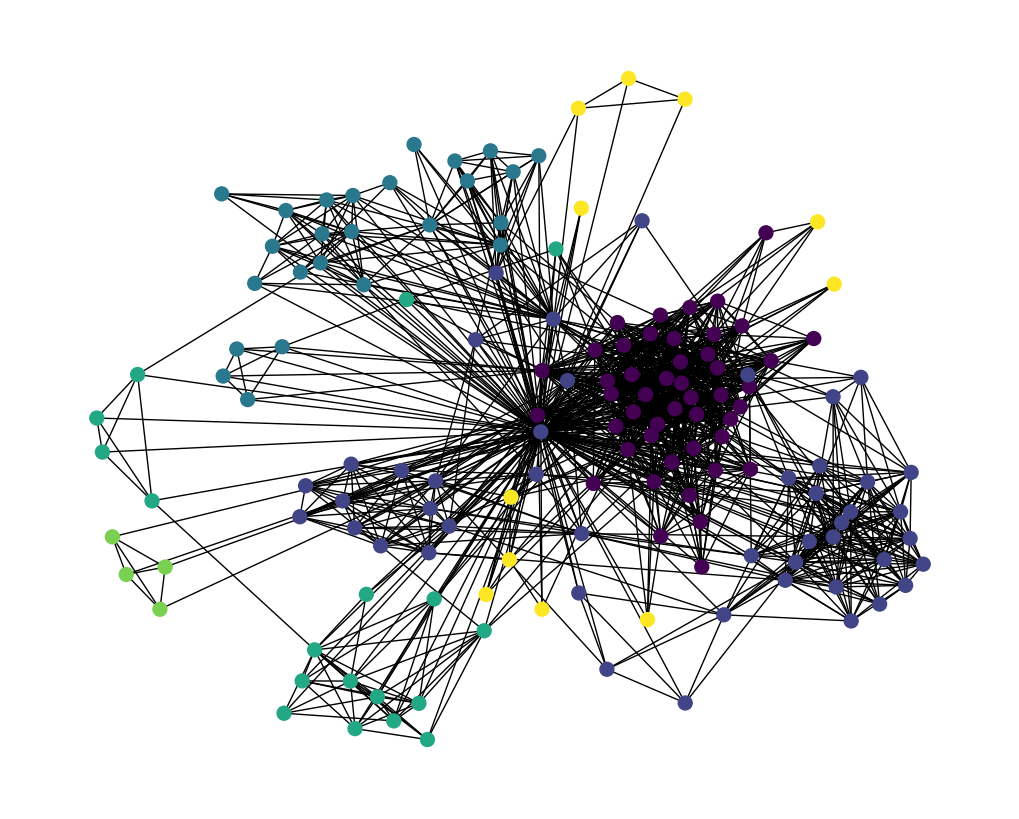

In [ ]:
partition, _ = simulated_annealing(G, K, s, P, T=1)
plot_network(G, partition)

Used Code Copilot and Wiki article: https://en.wikipedia.org/wiki/Simulated_annealing